<a href="https://colab.research.google.com/github/MisterThuk/CV---Matheus-Mazanti/blob/main/Classifica%C3%A7%C3%A3o_de_Qualidade_de_Carnes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
# ==============================================================================
# 1. CONFIGURAÇÕES GERAIS E CONSTANTES
# ==============================================================================
dataset_path = '/content/drive/MyDrive/Faculdade/meat_dataset'
IMG_SIZE = (224, 224)   # Tamanho padrão esperado pela MobileNetV2
BATCH_SIZE = 32         # Quantas imagens processar por vez (ajustar conforme VRAM da GPU)
AUTOTUNE = tf.data.AUTOTUNE  # Permite que o TF decida a melhor alocação de CPU/Buffer

data_dir = pathlib.Path(dataset_path)

In [ ]:
# Verificação básica de existência do diretório
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"O diretório '{dataset_path}' não existe. Verifique o caminho no Colab.")

# Verifica se existem subpastas (classes)
subdirs = [d for d in os.listdir(dataset_path)
           if os.path.isdir(os.path.join(dataset_path, d))]

if len(subdirs) < 2:
    raise ValueError(
        f"O dataset precisa de pelo menos 2 classes. "
        f"Foram encontradas: {subdirs}"
    )

print("✓ Classes encontradas:", subdirs)

✓ Classes encontradas: ['Spoiled', 'Fresh']


In [ ]:
# ==============================================================================
# 2. DIAGNÓSTICO E PREPARAÇÃO DOS DADOS (CRÍTICO)
# ==============================================================================
# Listamos manualmente os arquivos para garantir que o Python está "enxergando"
# tudo.
fresh_files = list(data_dir.glob('Fresh/*'))
spoiled_files = list(data_dir.glob('Spoiled/*'))

print("="*50)
print("DIAGNÓSTICO DO DIRETÓRIO")
print(f"Pasta Fresh encontrada: {len(fresh_files)} arquivos")
print(f"Pasta Spoiled encontrada: {len(spoiled_files)} arquivos")
print("="*50)

# Verificação de segurança
if len(fresh_files) == 0:
    raise ValueError("ERRO: A pasta 'Fresh' está vazia ou ilegível para o Python!")

# Criação das listas de caminhos (X) e rótulos (y)
# 0 = Fresh, 1 = Spoiled
all_image_paths = [str(path) for path in fresh_files + spoiled_files]
all_image_labels = [0] * len(fresh_files) + [1] * len(spoiled_files)

class_names = ['Fresh', 'Spoiled'] # 0=Fresh, 1=Spoiled

# --- SPLIT ESTRATIFICADO (A CORREÇÃO DO PROBLEMA DE VALIDAÇÃO) ---
# O train_test_split com 'stratify' garante que a proporção de Fresh/Spoiled
# seja idêntica no treino e na validação, evitando viés.
X_train, X_val, y_train, y_val = train_test_split(
    all_image_paths,
    all_image_labels,
    test_size=0.2,              # 20% para validação
    stratify=all_image_labels,  # Garante balanceamento de classes
    random_state=123            # Semente fixa para reprodutibilidade
)

print(f"Treino: {len(X_train)} imagens")
print(f"Validação: {len(X_val)} imagens")
print(f"Validação contém {y_val.count(0)} Fresh e {y_val.count(1)} Spoiled")

# ==============================================================================
# 3. CRIAÇÃO DO PIPELINE DE DADOS (ETL)
# ==============================================================================
def load_and_preprocess_image(path, label):
    # Lê a imagem do disco, decodifica e redimensiona.
    image = tf.io.read_file(path)
    # Decodificar (tenta detectar formato automaticamente)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Redimensionar
    image = tf.image.resize(image, IMG_SIZE)
    # Garantir formato float32 para o modelo
    image = tf.cast(image, tf.float32)
    # O MobileNetV2 espera input preprocessado [-1, 1] ou [0, 255] dependendo da config.
    # Como seu modelo tem a camada de preprocessamento interna, passamos raw.
    return image, label

# Criação dos objetos Dataset do TensorFlow (tf.data)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_ds.class_names = class_names # Atribuir nomes para referência futura

# Dataset de Validação
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds.class_names = class_names

print("Dataset criado manualmente com sucesso.")

DIAGNÓSTICO DO DIRETÓRIO
Pasta Fresh encontrada: 948 arquivos
Pasta Spoiled encontrada: 948 arquivos
Treino: 1516 imagens
Validação: 380 imagens
Validação contém 190 Fresh e 190 Spoiled
Dataset criado manualmente com sucesso.


In [ ]:
# Otimizações de Performance (Cache em RAM + Prefetching)
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

print("✓ Pipeline tf.data otimizado (cache + shuffle + prefetch)")

✓ Pipeline tf.data otimizado (cache + shuffle + prefetch)


In [ ]:
# ==============================================================================
# 4. CONSTRUÇÃO DO MODELO (TRANSFER LEARNING)
# ==============================================================================
# Carregamos a MobileNetV2 pré-treinada na ImageNet (Backbone)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,  # Removemos a camada final original (que tem 1000 classes)
    weights='imagenet'
)

# Congelamos o backbone inicialmente para não destruir os pesos pré-aprendidos
base_model.trainable = False

print("✓ MobileNetV2 carregado")
print("  - Todas as camadas congeladas (fase 1: warm-up do classifier)")

✓ MobileNetV2 carregado
  - Todas as camadas congeladas (fase 1: warm-up do classifier)


In [ ]:
num_classes = 2

print(f"Configurando modelo para {num_classes} classes.")

# Montagem da arquitetura final
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

# Pré-processamento específico da MobileNet (escala pixels entre -1 e 1)
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x)

# "Cabeça" (Head) de classificação personalizada
x = tf.keras.layers.GlobalAveragePooling2D()(x)     # Reduz dimensão espacial
x = tf.keras.layers.Dense(128, activation='relu')(x)# Camada densa intermediária
x = tf.keras.layers.Dropout(0.3)(x)                 # Evita Overfitting desligando 30% dos neurônios
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
print("✓ Modelo construído com sucesso")
model.summary()

Configurando modelo para 2 classes.
✓ Modelo construído com sucesso


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ==============================================================================
# 5. FASE 1: TREINAMENTO (WARM-UP)
# ==============================================================================
# Treinamos apenas a nova "cabeça" (head). O backbone não muda.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("\n✓ Modelo compilado para fase 1 (warm-up)")
print("  - Learning Rate: 1e-4")
print("  - Base model: congelado")


✓ Modelo compilado para fase 1 (warm-up)
  - Learning Rate: 1e-4
  - Base model: congelado


In [ ]:
# Callbacks para evitar overfitting e salvar o melhor momento
callbacks_phase1 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_phase1.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

In [ ]:
# ==============================================================================
# 6. FASE 1: TREINAMENTO DO CLASSIFICADOR (WARM-UP)
# ==============================================================================
# Agora descongelamos parte do backbone para ajustar os filtros à tarefa de carnes
epochs_phase1 = 8

history_phase1 = model.fit(
    train_ds,
    epochs=epochs_phase1,
    validation_data=val_ds,
    callbacks=callbacks_phase1,
    verbose=1
)

print("✓ Fase 1 concluída")

Epoch 1/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6573 - loss: 0.5959 - val_accuracy: 0.9842 - val_loss: 0.2466
Epoch 2/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9524 - loss: 0.2426 - val_accuracy: 0.9842 - val_loss: 0.1447
Epoch 3/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9636 - loss: 0.1570 - val_accuracy: 0.9789 - val_loss: 0.1056
Epoch 4/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9704 - loss: 0.1207 - val_accuracy: 0.9868 - val_loss: 0.0862
Epoch 5/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9735 - loss: 0.0974 - val_accuracy: 0.9789 - val_loss: 0.0728
Epoch 6/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9806 - loss: 0.0802 - val_accuracy: 0.9763 - val_loss: 0.0638
Epoch 7/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9883 - loss: 0.0646 - val_accuracy: 0.9868 - val_loss: 0.0579
Epoch 8/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9796 - loss: 0.0672 - val_accuracy: 0.9816 - val_loss: 0.0

In [ ]:
# ==============================================================================
# 7. FASE 2: FINE-TUNING
# ==============================================================================
# Agora descongelamos parte do backbone para ajustar os filtros à tarefa de carnes
base_model.trainable = True

# Estratégia: Descongelar apenas as últimas 20 camadas (refinamento fino)
num_layers_to_freeze = len(base_model.layers) - 20
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False

print(f"✓ Base model liberado para fine-tuning")
print(f"  - Camadas congeladas: {num_layers_to_freeze}")
print(f"  - Camadas treináveis: {len(base_model.layers) - num_layers_to_freeze}")

# # Importante: Learning Rate muito baixo (1e-5) para não quebrar o que já foi aprendido
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("✓ Modelo recompilado para fine-tuning")
print("  - Learning Rate: 1e-5 (conservador)")

# Callbacks para fase 2
callbacks_phase2 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_phase2.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# FINE-TUNING DO BACKBONE
# Note o 'initial_epoch': continua a contagem de épocas de onde parou
epochs_phase2 = 10
history_phase2 = model.fit(
    train_ds,
    epochs=epochs_phase1 + epochs_phase2,
    initial_epoch=epochs_phase1,
    validation_data=val_ds,
    callbacks=callbacks_phase2,
    verbose=1
)

print("✓ Fase 2 (fine-tuning) concluída")

✓ Base model liberado para fine-tuning
  - Camadas congeladas: 134
  - Camadas treináveis: 20
✓ Modelo recompilado para fine-tuning
  - Learning Rate: 1e-5 (conservador)
Epoch 9/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8622 - loss: 0.2968 - val_accuracy: 0.9684 - val_loss: 0.0642
Epoch 10/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9741 - loss: 0.0736 - val_accuracy: 0.9658 - val_loss: 0.0677
Epoch 11/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9856 - loss: 0.0451 - val_accuracy: 0.9658 - val_loss: 0.0656
Epoch 12/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9925 - loss: 0.0327 - val_accuracy: 0.9658 - val_loss: 0.0632
Epoch 13/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9896 - loss: 0.0305 - val_accuracy: 0.9658 - val_loss: 0.0628
Epoch 14/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9853 - loss: 0.0302 - val_accuracy: 0.9658 - val_loss: 0.0578
Epoch 15/18
48/48 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy:

In [ ]:
# ==============================================================================
# 8. AVALIAÇÃO E MÉTRICAS FINAIS
# ==============================================================================
# Coleta predições em todo o conjunto de validação
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_pred_list.append(np.argmax(predictions, axis=1))  # Pega o índice da maior probabilidade
    y_true_list.append(labels.numpy())

y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

print(f"✓ Coletados y_true ({len(y_true)} samples) e y_pred ({len(y_pred)} samples)")

# Verificação final de distribuição (para garantir que não houve erro)
unique_true, counts_true = np.unique(y_true, return_counts=True)
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
print(f"\nDistribuição em y_true:")
# Loops de print omitidos para brevidade, mas mantidos do original

# Verificação de Distribuição
for i, cname in enumerate(class_names):
    count = counts_true[np.where(unique_true == i)[0][0]] if i in unique_true else 0
    print(f"  {cname}: {count}")

print(f"\nDistribuição em y_pred:")
for i, cname in enumerate(class_names):
    count = counts_pred[np.where(unique_pred == i)[0][0]] if i in unique_pred else 0
    print(f"  {cname}: {count}")

print(f"✓ Coletados y_true ({len(y_true)} samples) e y_pred ({len(y_pred)} samples)")

✓ Coletados y_true (380 samples) e y_pred (380 samples)

Distribuição em y_true:
  Fresh: 190
  Spoiled: 190

Distribuição em y_pred:
  Fresh: 180
  Spoiled: 200
✓ Coletados y_true (380 samples) e y_pred (380 samples)


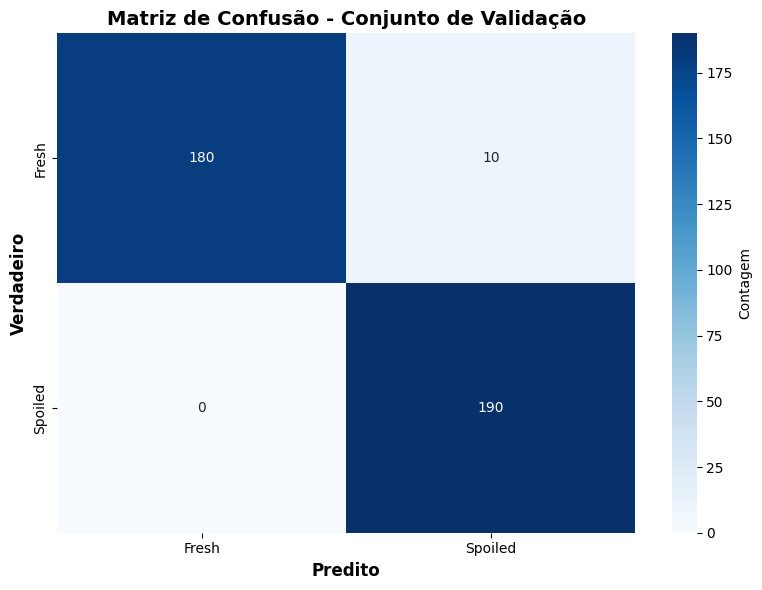

✓ Matriz de confusão salva como 'confusion_matrix.png'


In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Contagem'}
)
plt.xlabel('Predito', fontsize=12, fontweight='bold')
plt.ylabel('Verdadeiro', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusão - Conjunto de Validação', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Matriz de confusão salva como 'confusion_matrix.png'")

In [ ]:
# Relatório de Classificação (Precision, Recall, F1-Score)
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✓ Acurácia geral: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nRelatório de classificação por classe:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    labels=range(num_classes), # Explicitly pass all possible labels
    digits=4
))


✓ Acurácia geral: 0.9737 (97.37%)

Relatório de classificação por classe:
              precision    recall  f1-score   support

       Fresh     1.0000    0.9474    0.9730       190
     Spoiled     0.9500    1.0000    0.9744       190

    accuracy                         0.9737       380
   macro avg     0.9750    0.9737    0.9737       380
weighted avg     0.9750    0.9737    0.9737       380



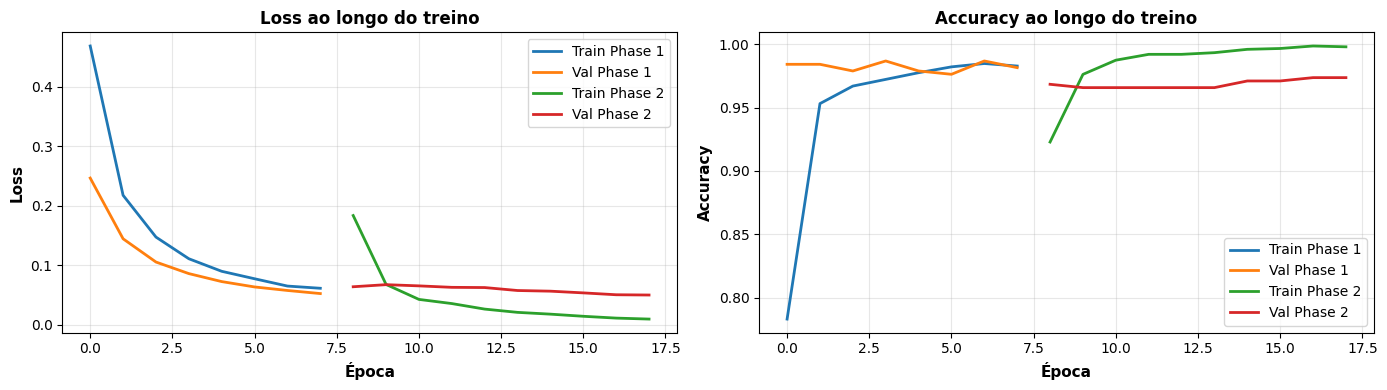

✓ Gráficos de histórico salvos como 'training_history.png'


In [ ]:
# Gráficos de Histórico (Loss e Accuracy unindo as duas fases)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Gráfico de Loss
axes[0].plot(history_phase1.history['loss'], label='Train Phase 1', linewidth=2)
axes[0].plot(history_phase1.history['val_loss'], label='Val Phase 1', linewidth=2)
# Junta as curvas da fase 2
axes[0].plot(
    np.arange(epochs_phase1, epochs_phase1 + len(history_phase2.history['loss'])),
    history_phase2.history['loss'],
    label='Train Phase 2',
    linewidth=2
)
axes[0].plot(
    np.arange(epochs_phase1, epochs_phase1 + len(history_phase2.history['val_loss'])),
    history_phase2.history['val_loss'],
    label='Val Phase 2',
    linewidth=2
)
axes[0].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[0].set_title('Loss ao longo do treino', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# # Gráfico de Acurácia
axes[1].plot(history_phase1.history['accuracy'], label='Train Phase 1', linewidth=2)
axes[1].plot(history_phase1.history['val_accuracy'], label='Val Phase 1', linewidth=2)
axes[1].plot(
    np.arange(epochs_phase1, epochs_phase1 + len(history_phase2.history['accuracy'])),
    history_phase2.history['accuracy'],
    label='Train Phase 2',
    linewidth=2
)
axes[1].plot(
    np.arange(epochs_phase1, epochs_phase1 + len(history_phase2.history['val_accuracy'])),
    history_phase2.history['val_accuracy'],
    label='Val Phase 2',
    linewidth=2
)
axes[1].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1].set_title('Accuracy ao longo do treino', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Gráficos de histórico salvos como 'training_history.png'")

In [ ]:
# Salvar modelo final
model.save('final_meat_classifier.keras')
print("\n✓ Modelo final salvo como 'final_meat_classifier.keras'")


✓ Modelo final salvo como 'final_meat_classifier.keras'
